In [79]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
with open('../../output/cv_df_list_prospective.pkl', 'rb') as file:
    data_file = pickle.load(file)

k = 6
prov = 10

input_data = data_file[k]
input_data['year_biweek'] = (input_data['year']-2006)*26 + (input_data['biweek'])

df = input_data.loc[input_data['province'] == prov]
df.head()

,province,year,biweek,date_sick,cases,year_biweek
0,10,2006,1,2006-01-01,265,1
1,10,2006,2,2006-01-15,162,2
2,10,2006,3,2006-01-29,211,3
3,10,2006,4,2006-02-12,113,4
4,10,2006,5,2006-02-26,165,5


In [81]:
true_data = pd.read_csv('../../data/province-biweek-counts.csv')
true_data['year_biweek'] = (true_data['year']-2006)*26 + (true_data['biweek'])

true_df = true_data.loc[true_data['province'] == prov]
true_df['date_sick'] == pd.to_datetime(true_df['date_sick'])
true_df.tail()

,province,year,biweek,date_sick,cases,year_biweek
203,10,2013,22,2013-10-22,478,204
204,10,2013,23,2013-11-05,466,205
205,10,2013,24,2013-11-19,373,206
206,10,2013,25,2013-12-03,311,207
207,10,2013,26,2013-12-17,128,208


### First Approach:

ie. smooth, then average

1. Fit a smoothing spline to the data for the entirety of the number of years (time interval of 12+ months)
2. Find the smoothed/fitted values for each month and add as a new column to the dataframe `(smooth_cases)`
3. Using these smoothed values, find the average value for each month

Those average values for each month are the predictions for the next year.

In [82]:
x = df['year_biweek'].tolist()
y = df['cases'].tolist()

y_sum = np.cumsum(y)

spl = UnivariateSpline(x, y_sum)
# plt.plot(x, y_sum, '*', x, spl(x), '-')

In [83]:
# get the predicted values and add to the dataframe

y_fit = spl(x)

y_smooth = np.diff(y_fit)
n = np.append(y_smooth[::-1], y_sum[0])
y_smooth = n[::-1]

df['smooth_cases'] = y_smooth

df.head()

,province,year,biweek,date_sick,cases,year_biweek,smooth_cases
0,10,2006,1,2006-01-01,265,1,265.000000
1,10,2006,2,2006-01-15,162,2,162.079185
2,10,2006,3,2006-01-29,211,3,210.791991
3,10,2006,4,2006-02-12,113,4,113.307280
4,10,2006,5,2006-02-26,165,5,164.738203


In [85]:
df['date_sick'] = pd.to_datetime(df['date_sick'])
df['month'] = 0

years = [2006, 2007, 2008, 2009, 2010, 2011, 2012]


df_w_month = pd.DataFrame(columns = ['province', 'year', 'biweek', 'date_sick', 'cases', 'year_biweek', 'smooth_cases', 'month'])
for year in years:
    for i in range(1, 12):
        month_start = str(year) + '-' + str(i)
        month_end = str(year) + '-' + str(i+1)
        date_range = (df['date_sick'] >= month_start) & (df['date_sick'] < month_end)
        one_month = df.loc[date_range]
        one_month['month'] = i
        df_w_month = df_w_month.append(one_month)

df_w_month.head()

,province,year,biweek,date_sick,cases,year_biweek,smooth_cases,month
0,10.0,2006.0,1.0,2006-01-01,265.0,1.0,265.000000,1.0
1,10.0,2006.0,2.0,2006-01-15,162.0,2.0,162.079185,1.0
2,10.0,2006.0,3.0,2006-01-29,211.0,3.0,210.791991,1.0
3,10.0,2006.0,4.0,2006-02-12,113.0,4.0,113.307280,2.0
4,10.0,2006.0,5.0,2006-02-26,165.0,5.0,164.738203,2.0


In [86]:
# now get the averages for each month
# currently this only works for one month ahead

monthly_avg = []
for i in range(1, 13):
    monthly_cases = df_w_month['smooth_cases'].loc[df_w_month['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg.append(avg)

print(monthly_avg)

# monthly_avg is the predictions

[184.62142522631586, 151.31357449244334, 122.35501609984333, 138.4942262634064, 224.62044714999493, 303.56547195542237, 356.15198995133699, 316.4741187392579, 323.55246334059808, 392.79511509638274, 413.24313583648598, nan]


[183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208]
[ 183.          185.27272727  187.54545455  189.81818182  192.09090909
  194.36363636  196.63636364  198.90909091  201.18181818  203.45454545
  205.72727273  208.        ]


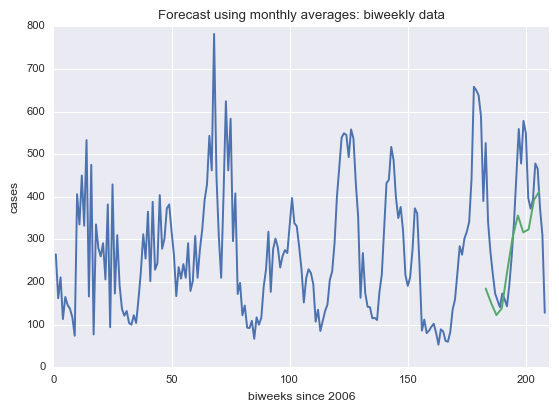

In [87]:
# MAKE SOME GRAPHS
sns.set()
plt.style.use('seaborn-paper')

biweeks = true_df['year_biweek'].tolist()
last_biweeks = biweeks[-26:]
print(last_biweeks)
last_months = np.linspace(last_biweeks[0], last_biweeks[len(last_biweeks)-1], 12)
print(last_month)
true_cases = true_df['cases']
forecast = monthly_avg

plt.title('Forecast using monthly averages: biweekly data')
plt.xlabel('biweeks since 2006')
plt.ylabel('cases')
plt.xlim(0, 210)

plt.plot(biweeks, true_cases, last_months, forecast)

plt.show()

In [113]:
def get_monthly_avg(df):
    # gets average values for each month in the df
    df['year_biweek'] = (df['year']-2006)*26 + (df['biweek'])

    # want to first smooth the data
    x = np.array(df['year_biweek'])
    y = np.array(df['cases'])
    y_sum = np.cumsum(y)

    spl = UnivariateSpline(x, y_sum)
    y_fit = spl(x)
    
    y_smooth = np.diff(y_fit)
    n = np.append(y_smooth[::-1], y_sum[0])
    y_smooth = n[::-1]
    df['smooth_cases'] = y_smooth

    df['date_sick'] = pd.to_datetime(df['date_sick'])
    df['month'] = 0
    years = [2006, 2007, 2008, 2009, 2010, 2011, 2012]

    df_w_month = pd.DataFrame(columns = ['province', 'year', 'biweek', 'date_sick', 'cases', 'year_biweek', 'smooth_cases', 'month'])
    for year in years:
        for i in range(1, 13):
            month_start = str(year) + '-' + str(i)
            if i < 12:
                month_end = str(year) + '-' + str(i+1)
            elif year != 2013:
                month_end = str(year+1) + '-' + str(1)
            else:
                month_end = '2013-12-31'
            date_range = (df['date_sick'] >= month_start) & (df['date_sick'] < month_end)
            one_month = df.loc[date_range]
            one_month['month'] = i
            df_w_month = df_w_month.append(one_month)

    print(df_w_month.tail())
            
    # then get the averages
    monthly_avg = []
    for i in range(1, 13):
        monthly_cases = df_w_month['smooth_cases'].loc[df_w_month['month'] == i].tolist()
        avg = np.mean(monthly_cases)
        monthly_avg.append(avg)

    return monthly_avg

In [114]:
df = data_file[0]
df = df.loc[df['province'] == prov]
print(get_monthly_avg(df))

    province    year  biweek  date_sick  cases  year_biweek  smooth_cases  \
21      10.0  2006.0    22.0 2006-10-22  206.0         22.0    207.798301   
22      10.0  2006.0    23.0 2006-11-05  382.0         23.0    379.768143   
23      10.0  2006.0    24.0 2006-11-19   94.0         24.0     96.013514   
24      10.0  2006.0    25.0 2006-12-03  429.0         25.0    427.773576   
25      10.0  2006.0    26.0 2006-12-17  173.0         26.0    173.442468   

    month  
21   10.0  
22   11.0  
23   11.0  
24   12.0  
25   12.0  
[212.61617238007832, 139.02658483749866, 141.71679137579508, 95.77833045352952, 370.61699451680909, 391.25332434655479, 390.16986447660065, 206.52162694090498, 270.55469130847405, 248.89672901213771, 237.89082879651232, 300.60802189571723]


### Second Approach

ie. average then smooth

1. Find the average number of cases for each month
2. Smooth the average values for each month (time interval of strictly 12 months)
3. Get the smoothed/fitted average values for each month

These are the predictions for the next year.

In [192]:
# now try finding the average value for each month
# fitting a spline to the monthly averages (lose years)
# then get the fitted values for each month

# start by getting the monthly averages
monthly_avg2 = []
for i in range(1, 13):
    monthly_cases = df['cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg2.append(avg)
    
# monthly_avg2 is the "true" monthly averages

[  437.5          302.25334334   290.8536056    261.15577502   416.78529476
   594.79149355   723.50185493   822.37489368   755.2108737    962.37191041
  1278.28850541   789.95961593]


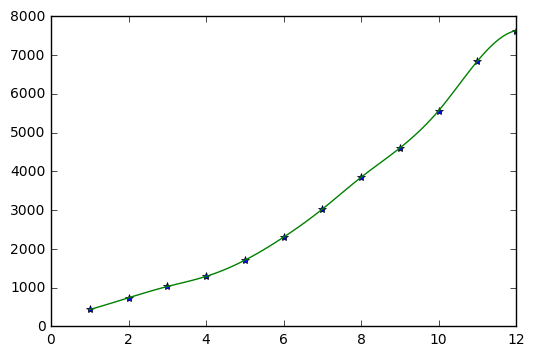

In [193]:
# get the fitted values
x2 = np.arange(1, 13)
y_sum2 = np.cumsum(monthly_avg2)
xnew2 = np.linspace(1, 12, num=100, endpoint=True)

spl2 = UnivariateSpline(x2, y_sum2)
plt.plot(x2, y_sum2, '*', xnew2, spl2(xnew2), '-')

y_fit2 = spl2(x2)
y_smooth2 = np.diff(y_fit2)
m = np.append(y_smooth2[::-1], y_sum2[0])
y_smooth2 = m[::-1]

print(y_smooth2)

# y_smooth2 are the predictions

### Comparing Approaches

In [194]:
# now compare the two approaches

diff_in_approaches = abs(monthly_avg - y_smooth2)
print(diff_in_approaches)

[ 0.08987247  0.78593428  1.72997854  2.08174393  1.02755608  1.2086858
  3.66535301  4.62883576  2.64813659  0.68660186  2.07274559  1.23148422]


In [196]:
true_avg_vs_first_approach = abs(np.array(monthly_avg) - np.array(monthly_avg2))
print(true_avg_vs_first_approach)

[  8.98724682e-02   2.32590935e-01   3.83584137e-01   4.25968904e-01
   3.12850838e-01   1.79352285e-04   5.63498080e-01   1.10372944e+00
   1.13726289e+00   6.85308545e-01   2.38749003e-01   2.81317114e-02]


In [197]:
true_avg_vs_second_approach = abs(np.array(y_smooth2) - np.array(monthly_avg2))
print(true_avg_vs_second_approach)

[ 0.          0.55334334  1.3463944   1.65577502  0.71470524  1.20850645
  3.10185493  3.52510632  1.5108737   1.37191041  2.31149459  1.25961593]


In [ ]:

'''
input_data['date_sick'] = pd.to_datetime(input_data['date_sick'])

data = pd.DataFrame({'date_sick': input_data['date_sick'], 'cases': input_data['cases']})
data = data.set_index('date_sick')

data

plt.plot(data)
'''